# Autoencoder for image compression using Deep learning

In [1]:
# !pip install -r requirements.txt

In [2]:
#import 
import cv2
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint 
import keras
import numpy as np
# !pip install imutils
import imutils
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix,classification_report
import os
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

# dataset path 
path = "D:/Image_datasets/brain_tumor_dataset"
# make sure in this dir two folder named "yes" and "no" is present. 

In [3]:
# this func crop out the unnecessary part of a image.
def crop_contour_brain_img(image, plot=False):
    grayscale=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayscale=cv2.GaussianBlur(grayscale,(5,5),0)
    threshhold_image=cv2.threshold(grayscale, 45, 255, cv2.THRESH_BINARY)[1]
    threshhold_image=cv2.erode(threshhold_image,None,iterations=2)
    threshhold_image=cv2.dilate(threshhold_image,None,iterations=2)
    
    countour=cv2.findContours(threshhold_image.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    countour=imutils.grab_contours(countour)
    c=max(countour, key=cv2.contourArea)
    
    extreme_pnts_left=tuple(c[c[:, :, 0].argmin()][0])
    extreme_pnts_right=tuple(c[c[:, :, 0].argmax()][0])
    extreme_pnts_top=tuple(c[c[:, :, 1].argmin()][0])
    extreme_pnts_bot=tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extreme_pnts_top[1]:extreme_pnts_bot[1],extreme_pnts_left[0]:extreme_pnts_right[0]]
#     to remove thresh holding comment the next line
    new_image= cv2.threshold(new_image, 100, 255, cv2.THRESH_BINARY,cv2.CHAIN_APPROX_SIMPLE)[1]
    if plot:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.tick_params(axis="both", which="both",
                        top=False,bottom=False,left=False,right=False,
                       labelbottom=False,labeltop=False,labelleft=False,
                       labelright=False)
        plt.title("original image")
        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.tick_params(axis="both", which="both",
                        top=False,bottom=False,left=False,right=False,
                       labelbottom=False,labeltop=False,labelleft=False,
                       labelright=False)
        plt.title("processed image")
        plt.show()
        
    return new_image

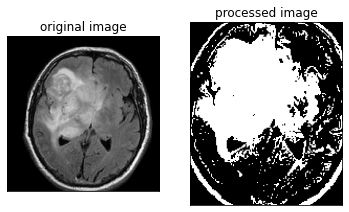

In [4]:
example_image=cv2.imread(path+"/yes/Y2.jpg")
img=crop_contour_brain_img(example_image,True)
# plt.imshow(img)
print()

In [5]:
image_size=(28,28)
hotencoder = OneHotEncoder()
hotencoder.fit([[0], [1]]) 
def load_images(path,type="jpg",target=0,images=[],orgimages=[],result=[]):
    for filepath in os.listdir(path):
        if filepath.split(".")[-1].lower()=="jpg" or filepath.split(".")[-1].lower()=="jpeg":
            img=cv2.imread(path+"/"+filepath)
            img=crop_contour_brain_img(img)
            img=cv2.resize(img,image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = np.expand_dims(img, 2)
            img=img.reshape(-1)
            orgimg=np.reshape(img,image_size)
            img=np.array(img)
            images.append(img)
            
            orgimages.append(orgimg)
            result.append(target)
    
    return [images,orgimages,result]

def show_image(datasets,num=4):  
    for i in range(num**2):
        plt.subplot(num, num, i+1)
        plt.imshow(datasets[i])
        plt.axis('off')


In [6]:
# load the image having brain cancer
images,orgimages,result=load_images(path+"/yes",target=0,images=[],orgimages=[],result=[])
# print(images.shape)
# show_image(images)
# print(result)


In [7]:
# loading the images not having brain cancer
images,orgimages,result=load_images(path+"/no",target=1,images=images,orgimages=orgimages,result=result)
# print(no_images.shape)
# show_image(images)
print("total images :",len(result),"| total targets :",len(images))

total images : 251 | total targets : 251


# validation of data,original data and target

In [8]:
# image dataset is stored in variable data
data=np.array(images)
print(data.shape)
data=data/255

(251, 784)


In [9]:
# unnecessary part for this project
orgdata=np.array(orgimages)
print(orgdata.shape)

(251, 28, 28)


In [10]:
target=np.array(result)
print(target.shape)

(251,)


## spliting of data,orgdata,target

In [11]:
def test_train_splitter(data,ratio=0.2):
    range=int(data.shape[0]*(1-0.2))
    x_train=data[:range]
    x_test=data[range:]
    return x_train,x_test

x_train,x_test=test_train_splitter(data)
print(x_train.shape,x_test.shape)

(200, 784) (51, 784)


# model starts here -----------:)

In [12]:
# importing model

import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.optimizers
import tensorflow.keras.datasets
import numpy
import matplotlib.pyplot

## encoder model

In [13]:
def get_encoder():
    # Encoder
    x = tensorflow.keras.layers.Input(shape=(784), name="encoder_input")

    encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="encoder_dense_1")(x)
    encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

    encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=64, name="encoder_dense_2")(encoder_activ_layer1)
    encoder_output = tensorflow.keras.layers.LeakyReLU(name="encoder_output")(encoder_dense_layer2)

    encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")
    return encoder

encoder=get_encoder()
encoder.summary()


Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 784)]             0         
_________________________________________________________________
encoder_dense_1 (Dense)      (None, 300)               235500    
_________________________________________________________________
encoder_leakyrelu_1 (LeakyRe (None, 300)               0         
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 64)                19264     
_________________________________________________________________
encoder_output (LeakyReLU)   (None, 64)                0         
Total params: 254,764
Trainable params: 254,764
Non-trainable params: 0
_________________________________________________________________


## decoder model

In [14]:
# Decoder
def get_decoder():
    decoder_input = tensorflow.keras.layers.Input(shape=(64), name="decoder_input")

    decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=300, name="decoder_dense_1")(decoder_input)
    decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

    decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=784, name="decoder_dense_2")(decoder_activ_layer1)
    decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer2)

    decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
    return decoder

decoder=get_decoder()
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 64)]              0         
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 300)               19500     
_________________________________________________________________
decoder_leakyrelu_1 (LeakyRe (None, 300)               0         
_________________________________________________________________
decoder_dense_2 (Dense)      (None, 784)               235984    
_________________________________________________________________
decoder_output (LeakyReLU)   (None, 784)               0         
Total params: 255,484
Trainable params: 255,484
Non-trainable params: 0
_________________________________________________________________


## autoencoder model

In [15]:
# Autoencoder
def autoencoder(encoder,decoder):
    ae_input = tensorflow.keras.layers.Input(shape=(784), name="AE_input")
    ae_encoder_output = encoder(ae_input)
    ae_decoder_output = decoder(ae_encoder_output)

    ae = tensorflow.keras.models.Model(ae_input, ae_decoder_output, name="AE")
    return ae


ae=autoencoder(encoder,decoder)
ae.summary()

    



Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
AE_input (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
encoder_model (Functional)   (None, 64)                254764    
_________________________________________________________________
decoder_model (Functional)   (None, 784)               255484    
Total params: 510,248
Trainable params: 510,248
Non-trainable params: 0
_________________________________________________________________


In [16]:
# RMSE
def rmse(y_true, y_predict):
    return tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict))

# AE Compilation
ae.compile(loss="mse", optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005))



C:\Users\TIRTHA\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
# preparing brain tumor dataset

x_train,x_test=test_train_splitter(data)
print(x_train.shape,x_test.shape)

x_train_org,x_test_org=test_train_splitter(orgdata)
print(x_train_org.shape,x_test_org.shape)

y_train,y_test=test_train_splitter(target)
print(y_train.shape,y_test.shape)



(200, 784) (51, 784)
(200, 28, 28) (51, 28, 28)
(200,) (51,)


In [18]:
# # Preparing MNIST Dataset
# (x_train_orig, y_train), (x_test_orig, y_test) = tensorflow.keras.datasets.mnist.load_data()
# x_train_orig = x_train_orig.astype("float32") / 255.0
# x_test_orig = x_test_orig.astype("float32") / 255.0

# x_train = numpy.reshape(x_train_orig, newshape=(x_train_orig.shape[0], numpy.prod(x_train_orig.shape[1:])))
# x_test = numpy.reshape(x_test_orig, newshape=(x_test_orig.shape[0], numpy.prod(x_test_orig.shape[1:])))
# # x_test_orig.shape,x_test.shape,y_test.shape
# y_test[0]

In [19]:
# Training AE
ae.fit(x_train, x_train, epochs=20, batch_size=10, shuffle=True, validation_data=(x_test, x_test))

encoded_images = encoder.predict(x_train)
decoded_images = decoder.predict(encoded_images)
decoded_images_orig = numpy.reshape(decoded_images, newshape=(decoded_images.shape[0], 28, 28))



Epoch 1/20
20/20 [==============================] - 4s 59ms/step - loss: 0.2068 - val_loss: 0.1420
Epoch 2/20
20/20 [==============================] - 0s 17ms/step - loss: 0.1450 - val_loss: 0.1357
Epoch 3/20
20/20 [==============================] - 0s 16ms/step - loss: 0.1330 - val_loss: 0.1269
Epoch 4/20
20/20 [==============================] - 0s 16ms/step - loss: 0.1234 - val_loss: 0.1221
Epoch 5/20
20/20 [==============================] - 0s 19ms/step - loss: 0.1149 - val_loss: 0.1187
Epoch 6/20
20/20 [==============================] - 0s 17ms/step - loss: 0.1073 - val_loss: 0.1161
Epoch 7/20
20/20 [==============================] - 0s 16ms/step - loss: 0.1006 - val_loss: 0.1143
Epoch 8/20
20/20 [==============================] - 0s 16ms/step - loss: 0.0948 - val_loss: 0.1133
Epoch 9/20
20/20 [==============================] - 0s 18ms/step - loss: 0.0895 - val_loss: 0.1127
Epoch 10/20
20/20 [==============================] - 0s 17ms/step - loss: 0.0848 - val_loss: 0.1106
Epoch 11/

# Analyzing compression ratio

encoder image shape (64,)
decoder image shape (784,)
compression ratio : 0.08163265306122448
compression percentage : 8.16 %


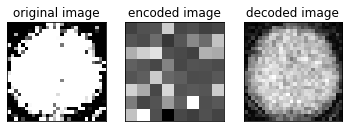

In [20]:
print("encoder image shape",encoded_images[0].shape)
print("decoder image shape",decoded_images[0].shape)

# compression_ratio=encoded_image_size / decoded_images or original images size
# as we have input of images of size (784,) and encoder output is(2,)

compression_ratio=encoded_images[0].shape[0] / decoded_images[0].shape[0]
print("compression ratio :", compression_ratio)

# compression percentage is compression ratio * 100
print("compression percentage :",round(compression_ratio*100,2),"%")

# comparition 
plt.figure()
plt.subplot(1,3,1)
original_sample=orgdata[0]
plt.imshow(original_sample,cmap="gray")
plt.tick_params(axis="both", which="both",
                top=False,bottom=False,left=False,right=False,
                labelbottom=False,labeltop=False,labelleft=False,
                labelright=False)
plt.title("original image")
        
plt.subplot(1,3,2)
encoded_sample = numpy.reshape(encoded_images, newshape=(decoded_images.shape[0], 8, 8))[0]
plt.imshow(encoded_sample,cmap="gray")
plt.tick_params(axis="both", which="both",
                top=False,bottom=False,left=False,right=False,
                labelbottom=False,labeltop=False,labelleft=False,
                labelright=False)
plt.title("encoded image")

plt.subplot(1,3,3)
decoded_sample=decoded_images_orig[0]
plt.imshow(decoded_sample,cmap="gray")
plt.tick_params(axis="both", which="both",
                top=False,bottom=False,left=False,right=False,
                labelbottom=False,labeltop=False,labelleft=False,
                labelright=False)
plt.title("decoded image")
plt.show()


In [21]:
64/784

0.08163265306122448

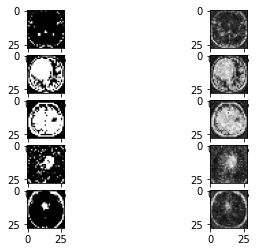

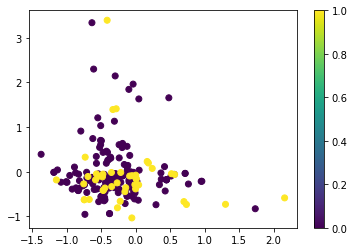

In [22]:
num_images_to_show = 5
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*2 + 1
    rand_ind = numpy.random.randint(low=0, high=x_train.shape[0])
    matplotlib.pyplot.subplot(num_images_to_show, 2, plot_ind)
    matplotlib.pyplot.imshow(x_train_org[rand_ind, :, :], cmap="gray")
    matplotlib.pyplot.subplot(num_images_to_show, 2, plot_ind+1)
    matplotlib.pyplot.imshow(decoded_images_orig[rand_ind, :, :], cmap="gray")

matplotlib.pyplot.figure()
matplotlib.pyplot.scatter(encoded_images[:, 0], encoded_images[:, 1], c=y_train)
matplotlib.pyplot.colorbar()